In [1]:
!pip install census

In [2]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census

# Census API Key
from config import api_key
#c = Census(api_key, year=2016)

In [3]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
def get_census(year):
    c = Census(api_key, year=year)
    census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E"), 
                         {'for': 'county:*'})
                        # {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
    census_pd = pd.DataFrame(census_data)

# Column Reordering
    census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "NAME": "Name", "county": "County"
                                      })

# Add in Poverty Rate (Poverty Count / Population)
    census_pd["Poverty Rate"] = 100 * \
        census_pd["Poverty Count"].astype(
            int) / census_pd["Population"].astype(int)

# Final DataFrame
    census_pd = census_pd[["Name","County", "Population", "Median Age", "Household Income",
                           "Per Capita Income", "Poverty Count", "Poverty Rate"]]

    census_pd['county_name'] = census_pd['Name'].str.replace(r" County,(.*)",'').str.upper()
    census_pd['state'] = census_pd['Name'].str.replace(r"(.*) County, ",'').str.upper()
# Visualize
    
    return census_pd

census_2012 = get_census(2012)
census_2012.head()
census_2012['year'] = 2012

census_2016 = get_census(2016)
census_2016.head()
census_2016['year'] = 2016

census_2020 = get_census(2020)
census_2020['year'] = 2020
census_2020.head()
census = pd.concat([census_2012,census_2016,census_2020])


C:\Users\nico.cosereanu\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\nico.cosereanu\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: The default value of regex will change from True to False in a future version.


In [4]:
census.dtypes

Name                  object
County                object
Population           float64
Median Age           float64
Household Income     float64
Per Capita Income    float64
Poverty Count        float64
Poverty Rate         float64
county_name           object
state                 object
year                   int64
dtype: object

In [5]:
census = census[census['Household Income']>0]
census

,Name,County,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,county_name,state,year
0,"Linn County, Missouri",115,12668.0,43.0,39028.0,20968.0,1678.0,13.245974,LINN,MISSOURI,2012
1,"Howell County, Missouri",091,40330.0,39.6,34148.0,17763.0,8187.0,20.300025,HOWELL,MISSOURI,2012
2,"Johnson County, Missouri",101,52964.0,29.7,47960.0,21375.0,8075.0,15.246205,JOHNSON,MISSOURI,2012
3,"Laclede County, Missouri",105,35507.0,39.1,39101.0,19788.0,6478.0,18.244290,LACLEDE,MISSOURI,2012
4,"Maries County, Missouri",125,9140.0,43.1,44885.0,21883.0,1286.0,14.070022,MARIES,MISSOURI,2012
...,...,...,...,...,...,...,...,...,...,...,...
3216,"Renville County, Minnesota",129,14572.0,44.0,58542.0,31243.0,1373.0,9.422180,RENVILLE,MINNESOTA,2020
3217,"Roseau County, Minnesota",135,15259.0,41.6,62304.0,31452.0,1133.0,7.425126,ROSEAU,MINNESOTA,2020
3218,"Sherburne County, Minnesota",141,96015.0,36.1,88671.0,36022.0,4953.0,5.158569,SHERBURNE,MINNESOTA,2020
3219,"Steele County, Minnesota",147,36710.0,39.2,68172.0,34648.0,2887.0,7.864342,STEELE,MINNESOTA,2020


In [6]:
census.to_csv("clean_census.csv", encoding="utf-8", index=False)

In [7]:
# # Save as a csv
# # Note to avoid any issues later, use encoding="utf-8"
winners_pd=pd.read_csv("countypres_2000-2020_with_winner.csv")
# winners_pd = winners_pd[((winners_pd['year'] == 2016) | (winners_pd['year'] == 2020)) & (winners_pd['state']== 'GEORGIA') & (winners_pd['county_name']== "WORTH")]
winners_pd

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode,Concat,Winner
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL,2000ALABAMAAUTAUGA,Republican
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL,2000ALABAMAAUTAUGA,Republican
2,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20220315,TOTAL,2000ALABAMAAUTAUGA,Republican
3,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20220315,TOTAL,2000ALABAMAAUTAUGA,Republican
4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL,2000ALABAMABALDWIN,Republican
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72612,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245,4032,20220315,TOTAL,2020WYOMINGWASHAKIE,Republican
72613,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,20220315,TOTAL,2020WYOMINGWESTON,Republican
72614,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,46,3560,20220315,TOTAL,2020WYOMINGWESTON,Republican
72615,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,OTHER,OTHER,47,3560,20220315,TOTAL,2020WYOMINGWESTON,Republican


In [8]:
# dem_pd = winners_pd[winners_pd['party'] == 'DEMOCRAT']
# dem_pd
#  #& ((winners_pd['party'] == 'DEMOCRAT') | (winners_pd['party'] == 'REPUBLICAN') )


In [9]:
# rep_pd = winners_pd[winners_pd['party'] == 'REPUBLICAN']
# rep_pd


In [10]:
# merge_pd=dem_pd.merge(rep_pd, on = ['year','state', 'county_name'])
# merge_pd.head(100)

In [11]:
# merge_pd['winner'] = np.where(merge_pd['candidatevotes_x'] > merge_pd['candidatevotes_y'], merge_pd['party_x'], merge_pd['party_y'])
# merge_pd = merge_pd[['year','state','county_name','winner']]
# merge_pd

In [12]:
#Dave's code filter only 2012 to 2020 democrats and republicans
winners_pd = winners_pd[((winners_pd['year'] == 2012) | (winners_pd['year'] == 2016) | (winners_pd['year'] == 2020))]
winners_pd = winners_pd[((winners_pd['party'] == 'DEMOCRAT') | (winners_pd['party'] == 'REPUBLICAN'))]
#winners_pd = winners_pd[((winners_pd['state']== 'GEORGIA') & (winners_pd['county_name']== "WORTH"))]
#winners_pd.head(100)
#drop duplicates when the state, county and year are the same
winners_pd=winners_pd.drop_duplicates(subset=['state_po','county_name', 'year'],keep='first')

In [13]:
winners_pd

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode,Concat,Winner
31166,2012,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,6363,23932,20220315,TOTAL,2012ALABAMAAUTAUGA,Republican
31169,2012,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,18424,85338,20220315,TOTAL,2012ALABAMABALDWIN,Republican
31172,2012,ALABAMA,AL,BARBOUR,1005.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,5912,11509,20220315,TOTAL,2012ALABAMABARBOUR,Democrat
31175,2012,ALABAMA,AL,BIBB,1007.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,2202,8420,20220315,TOTAL,2012ALABAMABIBB,Republican
31178,2012,ALABAMA,AL,BLOUNT,1009.0,US PRESIDENT,BARACK OBAMA,DEMOCRAT,2970,24006,20220315,TOTAL,2012ALABAMABLOUNT,Republican
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72597,2020,WYOMING,WY,SWEETWATER,56037.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,3823,16698,20220315,TOTAL,2020WYOMINGSWEETWATER,Republican
72601,2020,WYOMING,WY,TETON,56039.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,9848,14787,20220315,TOTAL,2020WYOMINGTETON,Democrat
72605,2020,WYOMING,WY,UINTA,56041.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,1591,9459,20220315,TOTAL,2020WYOMINGUINTA,Republican
72609,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,651,4032,20220315,TOTAL,2020WYOMINGWASHAKIE,Republican


In [14]:
#merge the two dataframes winner and census to get a dataframe with winners per state/county and year

cleaned_census_data = pd.merge(census, winners_pd, how='left', left_on=['year','state', 'county_name'], right_on=['year','state', 'county_name'])

cleaned_census_data = cleaned_census_data[['year','state','state_po','county_name','Population','Median Age', 'Household Income', 'Per Capita Income', 'Poverty Rate', 'Winner']]
cleaned_census_data

,year,state,state_po,county_name,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,MISSOURI,MO,LINN,12668.0,43.0,39028.0,20968.0,13.245974,Republican
1,2012,MISSOURI,MO,HOWELL,40330.0,39.6,34148.0,17763.0,20.300025,Republican
2,2012,MISSOURI,MO,JOHNSON,52964.0,29.7,47960.0,21375.0,15.246205,Republican
3,2012,MISSOURI,MO,LACLEDE,35507.0,39.1,39101.0,19788.0,18.244290,Republican
4,2012,MISSOURI,MO,MARIES,9140.0,43.1,44885.0,21883.0,14.070022,Republican
...,...,...,...,...,...,...,...,...,...,...
9656,2020,MINNESOTA,MN,RENVILLE,14572.0,44.0,58542.0,31243.0,9.422180,Republican
9657,2020,MINNESOTA,MN,ROSEAU,15259.0,41.6,62304.0,31452.0,7.425126,Republican
9658,2020,MINNESOTA,MN,SHERBURNE,96015.0,36.1,88671.0,36022.0,5.158569,Republican
9659,2020,MINNESOTA,MN,STEELE,36710.0,39.2,68172.0,34648.0,7.864342,Republican


In [15]:
#drop the states that don't have an abbreviation
cleaned_census_data.dropna(subset =["state_po"],inplace=True)
# cleaned_census_data.drop_duplicates()
# cleaned_census_data

In [16]:
#cleaned_census_data.dropna(inplace=True)

In [17]:
#quick check
cleaned_census_data.groupby('year').sum()

,Population,Median Age,Household Income,Per Capita Income,Poverty Rate
year,,,,,
2012,298426160.0,121679.0,136661286.0,69993693.0,46882.007175
2016,307582561.0,123750.4,143834484.0,74999435.0,47062.421839
2020,315412439.0,125295.5,165020057.0,87102240.0,41776.289741


In [18]:
#print file
cleaned_census_data.to_csv("clean_data.csv", encoding="utf-8", index=False)

Random Forest Model

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [20]:
df = pd.read_csv('clean_data.csv')

In [21]:
df.dtypes

year                   int64
state                 object
state_po              object
county_name           object
Population           float64
Median Age           float64
Household Income     float64
Per Capita Income    float64
Poverty Rate         float64
Winner                object
dtype: object

In [22]:
# for col in df.columns:
#     if df[col].dtype == 'object':
#         df[col] = pd.to_numeric(df[col], errors='coerce')

In [23]:
#drop non feature columns that are objects
df = df.drop(columns=['state', 'county_name','state_po'])

In [24]:
#pd.get_dummies(X['state_po'])

In [25]:
df.dtypes

year                   int64
Population           float64
Median Age           float64
Household Income     float64
Per Capita Income    float64
Poverty Rate         float64
Winner                object
dtype: object

In [26]:
#df.dropna(inplace=True)
        
X = df.drop('Winner', axis=1)
y = df['Winner']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
#np.seterr(divide='ignore', invalid='ignore')

In [29]:
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.855715871254162


[0.02810507 0.29913808 0.150774   0.15634069 0.18382481 0.18181734]


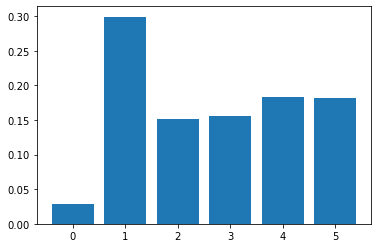

In [30]:
features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

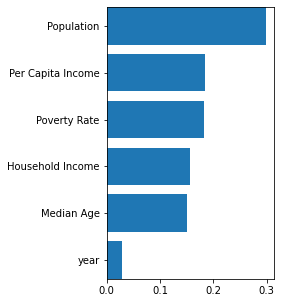

In [31]:
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(3,5)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

Logistical

In [32]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)
sel.get_support()

array([False,  True, False, False,  True,  True])

In [33]:
X.shape
y.shape

(9007,)

In [34]:
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

C:\Users\nico.cosereanu\Anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [35]:
clf = LogisticRegression().fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

ValueError: Found input variables with inconsistent numbers of samples: [8106, 6755]